In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchsummary

In [ ]:
!pip install easyocr
!pip install torch torchvision torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.9/422.9 kB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt

In [ ]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define all characters
characters = "0123456789กขคฆงจฉชซญฎฏฐฑฒณดตถทธนบปผฝพฟภมยรลวศษสหฬอฮ "

Using device: cuda


In [ ]:
#############################################################

In [ ]:
# Create Dataset
class OCRDataset(Dataset):
    def __init__(self, img_dir, label_path, transform=None):
        self.img_dir = img_dir
        self.label_path = label_path
        self.transform = transform
        self.image_paths = []
        self.labels = []

        with open(label_path, "r", encoding="utf-8") as f:
            for line in f:
                parts = line.strip().split(", ", 1)  # Split only at first comma
                if len(parts) == 2:
                    img_name, text = parts
                    img_name = img_name.strip()
                    text = text.strip('"')  # Remove quotes around the text
                    self.image_paths.append(img_name)
                    self.labels.append(text)
                else:
                    print(f"Skipping malformed line: {line}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = self.image_paths[idx]
        label = self.labels[idx]

        try:
            img_path = os.path.join(self.img_dir, img_name)
            img = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_name}: {e}")
            # Create a blank image as fallback
            img = Image.new('RGB', (128, 32), color='white')

        if self.transform:
            img = self.transform(img)

        # Convert text to numbers
        label_encoded = []
        for c in label:
            if c in characters:
                label_encoded.append(characters.index(c))
            else:
                # Handle unknown characters
                print(f"Warning: Character '{c}' not in the character set!")
                label_encoded.append(characters.index(' '))

        return img, torch.tensor(label_encoded, dtype=torch.long)

In [ ]:
# Transformation
transform = transforms.Compose([
    transforms.Resize((32, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
# Collate function - แก้ไขให้เหมาะสมกับ CTCLoss
def ctc_collate_fn(batch):
    # Sort batch by decreasing label length
    batch.sort(key=lambda x: len(x[1]), reverse=True)

    # Separate images and labels
    images, labels = zip(*batch)

    # Get label lengths
    label_lengths = torch.LongTensor([len(label) for label in labels])

    # Stack all images
    images = torch.stack(images)

    # สร้าง labels เป็น tensor เดียว (flat)
    labels_flat = []
    for label in labels:
        labels_flat.extend(label)

    labels_tensor = torch.tensor(labels_flat, dtype=torch.long)

    # Debug information
    # print(f"Batch size: {len(batch)}")
    # print(f"Images shape: {images.shape}")
    # print(f"Labels tensor shape: {labels_tensor.shape}")
    # print(f"Label lengths shape: {label_lengths.shape}")

    return images, labels_tensor, label_lengths

In [ ]:
# Create DataLoader
train_dataset = OCRDataset("/content/drive/MyDrive/MiniPro_Ml/ocr_dataset/custom_easyocr/train_images",
                          "/content/drive/MyDrive/MiniPro_Ml/ocr_dataset/custom_easyocr/train_labels.txt",
                          transform=transform)

print(f"Dataset size: {len(train_dataset)}")
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=ctc_collate_fn)


Dataset size: 145


In [ ]:
# CRNN model
class CRNN(nn.Module):
    def __init__(self, num_classes):
        super(CRNN, self).__init__()

        # CNN layers
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 2), (2, 1), (0, 1)),
        )

        # Calculate the output size after CNN
        self.cnn_output_height = 4  # 32 / (2*2*2) = 4

        # RNN layer
        self.rnn = nn.GRU(256 * self.cnn_output_height, 256, bidirectional=True, batch_first=True)

        # Fully connected layer
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        # CNN feature extraction
        x = self.cnn(x)

        # Prepare for RNN - reshape to (batch, seq_len, input_size)
        b, c, h, w = x.size()
        x = x.permute(0, 3, 1, 2)  # [b, w, c, h]
        x = x.reshape(b, w, c * h)  # [b, w, c*h]

        # RNN sequence modeling
        x, _ = self.rnn(x)

        # Log softmax for CTC loss
        x = self.fc(x)
        x = nn.functional.log_softmax(x, dim=2)

        return x

In [ ]:
# ฟังก์ชันสำหรับการพล็อตกราฟ accuracy และ loss
def plot_training_results(epochs, train_losses, train_accuracies, val_losses=None, val_accuracies=None):
    """
    พล็อตกราฟแสดงผลการเทรนนิ่งทั้ง loss และ accuracy

    Parameters:
    -----------
    epochs : list
        รายการเลข epoch (เช่น [1, 2, 3, 4, 5])
    train_losses : list
        รายการค่า loss ของการเทรนนิ่งในแต่ละ epoch
    train_accuracies : list
        รายการค่า accuracy ของการเทรนนิ่งในแต่ละ epoch
    val_losses : list, optional
        รายการค่า loss ของ validation set (ถ้ามี)
    val_accuracies : list, optional
        รายการค่า accuracy ของ validation set (ถ้ามี)
    """
    # สร้าง figure ที่มี 2 subplot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # พล็อตกราฟ Loss
    ax1.plot(epochs, train_losses, 'b-o', label='Training Loss')
    if val_losses:
        ax1.plot(epochs, val_losses, 'r-o', label='Validation Loss')
    ax1.set_title('Training & Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # พล็อตกราฟ Accuracy
    ax2.plot(epochs, train_accuracies, 'b-o', label='Training Accuracy')
    if val_accuracies:
        ax2.plot(epochs, val_accuracies, 'r-o', label='Validation Accuracy')
    ax2.set_title('Training & Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig('training_results.png')
    plt.show()

In [ ]:
def calc_accuracy(preds, targets, target_lengths):
    """
    คำนวณความแม่นยำตามตัวอักษร (character-level)

    Parameters:
    -----------
    preds : torch.Tensor
        ผลลัพธ์จากโมเดล shape [T, B, C]
    targets : torch.Tensor
        เป้าหมายที่ถูกต้อง (flatten)
    target_lengths : torch.Tensor
        ความยาวของแต่ละเป้าหมาย

    Returns:
    --------
    float
        ค่าความแม่นยำเฉลี่ยตามตัวอักษร (0-100%)
    """
    preds = preds.permute(1, 0, 2)  # [T, B, C] -> [B, T, C]
    batch_size = preds.size(0)
    preds = preds.log_softmax(2).argmax(2)  # [B, T]

    correct_chars = 0
    total_chars = 0

    # แยกเป้าหมายจาก tensor ที่แบนออกมา
    target_offset = 0
    for i in range(batch_size):
        target_len = target_lengths[i].item()
        target = targets[target_offset:target_offset + target_len]
        target_offset += target_len

        # ตัดเอาเฉพาะความยาวที่เท่ากับเป้าหมาย
        pred = preds[i, :target_len]

        # นับจำนวนตัวอักษรที่ทำนายถูกต้อง
        correct_chars += torch.sum(pred.eq(target)).item()
        total_chars += target_len

    return (correct_chars / total_chars) * 100.0 if total_chars > 0 else 0.0

In [ ]:
# Create model
model = CRNN(num_classes=len(characters) + 1)  # +1 for blank in CTC
model = model.to(device)
print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")

# Loss and Optimizer
criterion = nn.CTCLoss(blank=len(characters), reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=0.001)

Model created with 2957749 parameters


In [ ]:
summary(model, input_size=(3, 32, 128))  # 3 channels (RGB), 32x128 image size

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 32, 128]           1,792
              ReLU-2          [-1, 64, 32, 128]               0
         MaxPool2d-3           [-1, 64, 16, 64]               0
            Conv2d-4          [-1, 128, 16, 64]          73,856
              ReLU-5          [-1, 128, 16, 64]               0
         MaxPool2d-6           [-1, 128, 8, 32]               0
            Conv2d-7           [-1, 256, 8, 32]         295,168
       BatchNorm2d-8           [-1, 256, 8, 32]             512
              ReLU-9           [-1, 256, 8, 32]               0
           Conv2d-10           [-1, 256, 8, 32]         590,080
             ReLU-11           [-1, 256, 8, 32]               0
        MaxPool2d-12           [-1, 256, 4, 33]               0
              GRU-13  [[-1, 33, 512], [-1, 2, 256]]               0
           Linear-14               

In [ ]:
# Training loop ที่ปรับปรุง
def train(num_epochs=5):
    model.train()

    # เก็บข้อมูลสำหรับการพล็อตกราฟ
    epochs = []
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        total_loss = 0
        total_accuracy = 0
        batch_count = 0

        for i, (images, labels, label_lengths) in enumerate(train_loader):
            # Move to device
            images = images.to(device)
            labels = labels.to(device)
            label_lengths = label_lengths.to(device)

            # Forward pass
            outputs = model(images)  # [batch_size, seq_len, num_classes]

            # เปลี่ยนรูปแบบของ outputs ให้เป็น [seq_len, batch_size, num_classes]
            outputs = outputs.permute(1, 0, 2)  # [T, B, C]

            # Get sequence length and batch size
            T = outputs.size(0)  # sequence length
            batch_size = outputs.size(1)  # batch size

            # Create input_lengths tensor
            input_lengths = torch.full(size=(batch_size,), fill_value=T, dtype=torch.long, device=device)

            # Zero gradients
            optimizer.zero_grad()

            try:
                # Compute loss
                loss = criterion(outputs, labels, input_lengths, label_lengths)

                # คำนวณ accuracy (สำหรับการดูประสิทธิภาพ)
                accuracy = calc_accuracy(outputs, labels, label_lengths)

                # Check if loss is valid
                if torch.isnan(loss) or torch.isinf(loss):
                    print(f"Warning: Loss is {loss.item()}, skipping batch")
                    continue

                # Backward and optimize
                loss.backward()
                optimizer.step()

                # Track statistics
                total_loss += loss.item()
                total_accuracy += accuracy
                batch_count += 1

                # แสดงผลทุกๆ 5 batch
                if (i + 1) % 5 == 0:
                    print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], "
                          f"Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%")

            except Exception as e:
                print(f"Error in batch {i}: {e}")
                print(f"Labels: {labels}")
                print(f"Label lengths: {label_lengths}")
                continue

        # คำนวณค่าเฉลี่ยสำหรับ epoch นี้
        if batch_count > 0:
            avg_loss = total_loss / batch_count
            avg_accuracy = total_accuracy / batch_count

            # เก็บข้อมูลสำหรับการพล็อตกราฟ
            epochs.append(epoch + 1)
            train_losses.append(avg_loss)
            train_accuracies.append(avg_accuracy)

            print(f"\nEpoch [{epoch+1}/{num_epochs}], "
                  f"Average Loss: {avg_loss:.4f}, Average Accuracy: {avg_accuracy:.2f}%")

    # บันทึกโมเดล
    torch.save(model.state_dict(), 'thai_ocr_model.pth')
    print("Training completed and model saved!")

    # พล็อตกราฟผลการเทรนนิ่ง
    plot_training_results(epochs, train_losses, train_accuracies)

    return train_losses, train_accuracies

Epoch [1/5], Batch [5/19], Loss: 1.5412, Accuracy: 31.15%
Epoch [1/5], Batch [10/19], Loss: 1.0748, Accuracy: 36.07%
Epoch [1/5], Batch [15/19], Loss: 1.6457, Accuracy: 35.00%

Epoch [1/5], Average Loss: 1.4415, Average Accuracy: 31.17%
Epoch [2/5], Batch [5/19], Loss: 1.1054, Accuracy: 36.67%
Epoch [2/5], Batch [10/19], Loss: 1.3845, Accuracy: 32.76%
Epoch [2/5], Batch [15/19], Loss: 1.5886, Accuracy: 30.00%

Epoch [2/5], Average Loss: 1.2441, Average Accuracy: 34.19%
Epoch [3/5], Batch [5/19], Loss: 1.2750, Accuracy: 30.51%
Epoch [3/5], Batch [10/19], Loss: 1.4293, Accuracy: 32.79%
Epoch [3/5], Batch [15/19], Loss: 1.4101, Accuracy: 31.67%

Epoch [3/5], Average Loss: 1.3606, Average Accuracy: 31.36%
Epoch [4/5], Batch [5/19], Loss: 1.3958, Accuracy: 35.00%
Epoch [4/5], Batch [10/19], Loss: 1.2015, Accuracy: 33.33%
Epoch [4/5], Batch [15/19], Loss: 1.1931, Accuracy: 35.59%

Epoch [4/5], Average Loss: 1.3121, Average Accuracy: 33.44%
Epoch [5/5], Batch [5/19], Loss: 1.3016, Accuracy: 2

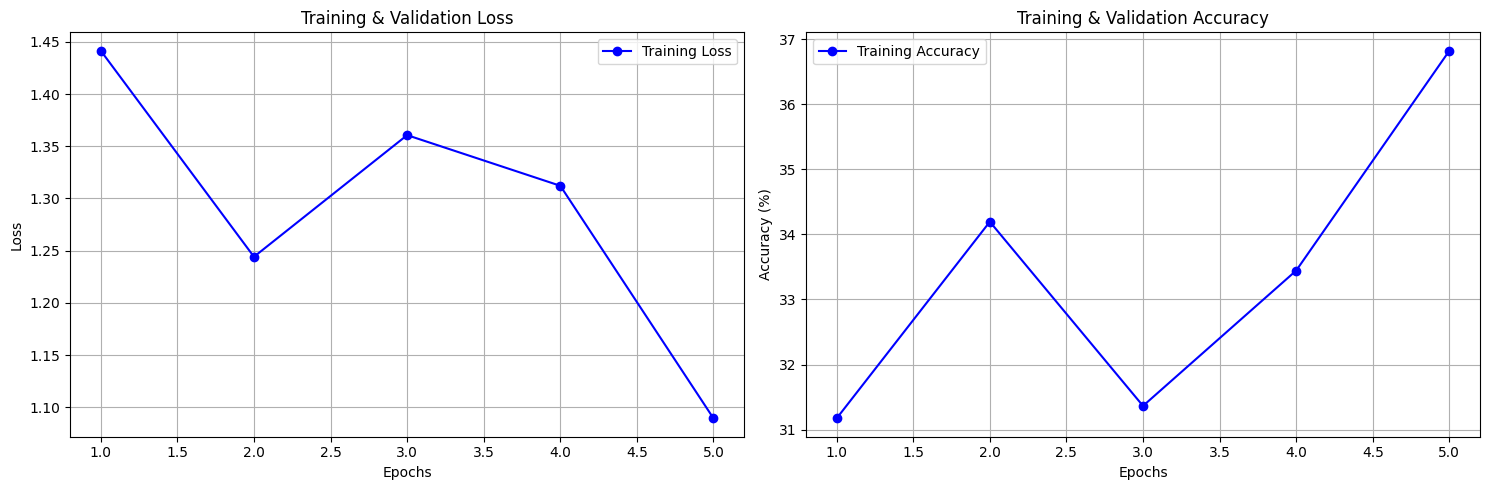

In [ ]:
losses, accuracies = train(num_epochs=5)

In [ ]:
# ฟังก์ชันสำหรับการทดสอบและทำนายข้อความ
def predict_text(model, image_path):
    """
    ทำนายข้อความจากรูปภาพ

    Parameters:
    -----------
    model : nn.Module
        โมเดล CRNN ที่ผ่านการเทรนนิ่งแล้ว
    image_path : str
        พาธไปยังรูปภาพที่ต้องการทำนาย

    Returns:
    --------
    str
        ข้อความที่ทำนาย
    """
    model.eval()

    # โหลดและเตรียมรูปภาพ
    img = Image.open(image_path).convert('RGB')
    img = transform(img).unsqueeze(0).to(device)  # [1, 3, 32, 128]

    with torch.no_grad():
        # ทำนาย
        outputs = model(img)  # [1, seq_len, num_classes]
        outputs = outputs.permute(1, 0, 2)  # [seq_len, 1, num_classes]

        # Greedy decoding (ตัวอย่างง่ายๆ)
        outputs = outputs.permute(1, 0, 2)  # [1, seq_len, num_classes]
        outputs = outputs.log_softmax(2).argmax(2).squeeze(0)  # [seq_len]

        # แปลงตัวเลขกลับเป็นข้อความ
        result = []
        prev_char = -1
        for char_index in outputs:
            char_index = char_index.item()
            # ข้ามอักขระว่าง (blank) และอักขระซ้ำ (CTC collapse)
            if char_index != len(characters) and char_index != prev_char:
                result.append(characters[char_index])
            prev_char = char_index

        # รวมผลลัพธ์เป็นข้อความ
        predicted_text = ''.join(result)

    return predicted_text

# ฟังก์ชันสำหรับการประเมินโมเดลกับชุดข้อมูลทดสอบ
def evaluate_model(model, test_loader):
    """
    ประเมินประสิทธิภาพของโมเดลกับชุดข้อมูลทดสอบ

    Parameters:
    -----------
    model : nn.Module
        โมเดล CRNN ที่ผ่านการเทรนนิ่งแล้ว
    test_loader : DataLoader
        DataLoader สำหรับชุดข้อมูลทดสอบ

    Returns:
    --------
    float
        ค่าความแม่นยำเฉลี่ย (0-100%)
    float
        ค่า loss เฉลี่ย
    """
    model.eval()
    total_loss = 0
    total_accuracy = 0
    batch_count = 0

    with torch.no_grad():
        for i, (images, labels, label_lengths) in enumerate(test_loader):
            # Move to device
            images = images.to(device)
            labels = labels.to(device)
            label_lengths = label_lengths.to(device)

            # Forward pass
            outputs = model(images)
            outputs = outputs.permute(1, 0, 2)  # [T, B, C]

            # Get sequence length and batch size
            T = outputs.size(0)
            batch_size = outputs.size(1)

            # Create input_lengths tensor
            input_lengths = torch.full(size=(batch_size,), fill_value=T, dtype=torch.long, device=device)

            try:
                # Compute loss
                loss = criterion(outputs, labels, input_lengths, label_lengths)

                # Calculate accuracy
                accuracy = calc_accuracy(outputs, labels, label_lengths)

                total_loss += loss.item()
                total_accuracy += accuracy
                batch_count += 1

            except Exception as e:
                print(f"Error in evaluation batch {i}: {e}")
                continue

    # คำนวณค่าเฉลี่ย
    if batch_count > 0:
        avg_loss = total_loss / batch_count
        avg_accuracy = total_accuracy / batch_count
        return avg_accuracy, avg_loss
    else:
        return 0.0, float('inf')

# ตัวอย่างการใช้งานฟังก์ชันทำนาย (หลังจากเทรนแล้ว)
# predicted_text = predict_text(model, "path/to/test/image.jpg")
# print(f"Predicted text: {predicted_text}")

# ตัวอย่างการเตรียม test loader (ถ้ามีชุดข้อมูลทดสอบ)
# test_dataset = OCRDataset("/path/to/test/images", "/path/to/test/labels.txt", transform=transform)
# test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=ctc_collate_fn)
# test_accuracy, test_loss = evaluate_model(model, test_loader)
# print(f"Test Accuracy: {test_accuracy:.2f}%, Test Loss: {test_loss:.4f}")

In [ ]:
predicted_text = predict_text(model, "/content/drive/MyDrive/MiniPro_Ml/ocr_dataset/custom_easyocr/train_images/plate_01.jpg")
print(f"Predicted text: {predicted_text}")

Predicted text: งก 5


In [ ]:
# ตัวอย่างการเตรียม test loader (ถ้ามีชุดข้อมูลทดสอบ)
test_dataset = OCRDataset("/content/drive/MyDrive/MiniPro_Ml/ocr_dataset/custom_easyocr/valid_images", "/content/drive/MyDrive/MiniPro_Ml/ocr_dataset/custom_easyocr/test_labels.txt", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=ctc_collate_fn)
test_accuracy, test_loss = evaluate_model(model, test_loader)
print(f"Test Accuracy: {test_accuracy:.2f}%, Test Loss: {test_loss:.4f}")

Test Accuracy: 17.43%, Test Loss: 4.6526


In [ ]:
# Save model
torch.save(model.state_dict(), 'new_thai_ocr_model.pth')
print("Training completed and model saved!")

Training completed and model saved!


In [ ]:
save_path = "/content/drive/MyDrive/MiniPro_Ml/model/new_thai_ocr_model.pth"
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to /content/drive/MyDrive/MiniPro_Ml/model/new_thai_ocr_model.pth
